<a href="https://colab.research.google.com/github/url-github/machine_learning_bigquery/blob/main/Time_Series_na_podstawie_Google_Analytics_UA_(dane_publiczne).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://cloud.google.com/bigquery-ml/docs/arima-single-time-series-forecasting-tutorial

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
%load_ext google.colab.data_table

Authenticated


-- 1. Sprawdzam dane historyczne:

In [2]:
%%bigquery --project empik-ga360

SELECT 
    parse_timestamp('%Y%m%d', date) true_date,
    sum(totals.visits) sesje

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` 
group by 1
order by 1 desc
limit 5

,true_date,sesje
0,2017-08-01 00:00:00+00:00,2556
1,2017-07-31 00:00:00+00:00,2620
2,2017-07-30 00:00:00+00:00,1799
3,2017-07-29 00:00:00+00:00,1597
4,2017-07-28 00:00:00+00:00,2433


-- 2. Dane historyczne ładuje do swojej tabeli:

In [3]:
%%bigquery --project empik-ga360

CREATE OR REPLACE TABLE `empik-ga360.pmackowka_ml.sesje` AS
SELECT 
    parse_timestamp('%Y%m%d', date) true_date,
    sum(totals.visits) sesje

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` 
group by 1
order by 1 desc

""


-- 3. Tworzenie modelu ML i wytrenowanie go na podstawie danych z pkt. 1

In [4]:
%%bigquery --project empik-ga360

CREATE OR REPLACE MODEL `empik-ga360.pmackowka_ml.arima_model`

OPTIONS(
    MODEL_TYPE= 'ARIMA_PLUS',
    TIME_SERIES_TIMESTAMP_COL= 'true_date',
    TIME_SERIES_DATA_COL= 'sesje', 
    auto_arima = TRUE, # algorytm automatycznie dostraja hiperparametry
    data_frequency = 'AUTO_FREQUENCY', # proces uczenia automatycznie określa częstotliwość danych wejściowych szeregów czasowych
    decompose_time_series = TRUE # w jaki sposób szeregi czasowe są prognozowane pobierając oddzielne składniki szeregu czasowego, takie jak sezonowość i efekt świąt
    -- HOLIDAY_REGION='US' HOLIDAY_REGION='PL'
) AS

SELECT 
    true_date,
    sesje
FROM
    `empik-ga360.pmackowka_ml.sesje`

""


-- 4. Sprawdzam metryki oceny wszystkich ocenianych modeli

Funkcja ML.ARIMA_EVALUATE wyświetla metryki oceny wszystkich modeli kandydujących ocenianych podczas procesu automatycznego dostrajania hiperparametrów.

In [5]:
%%bigquery --project empik-ga360

SELECT *
FROM ML.ARIMA_EVALUATE(MODEL pmackowka_ml.arima_model)
limit 5

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,3,1,2,False,-2452.119363,4916.238727,39836.544675,[WEEKLY],False,False,True,
1,1,1,1,False,-2464.037631,4934.075263,42722.325332,[WEEKLY],False,False,True,
2,1,1,1,True,-2463.459921,4934.919842,42584.911509,[WEEKLY],False,False,True,
3,1,1,2,False,-2463.920390,4935.840779,42695.145036,[WEEKLY],False,False,True,
4,2,1,1,False,-2463.939598,4935.879195,42699.161831,[WEEKLY],False,False,True,


Definiują model ARIMA:

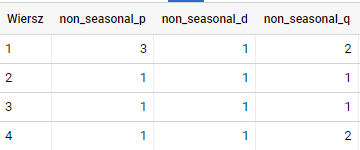

Istotne dla procesu dopasowywania modelu ARIMA:

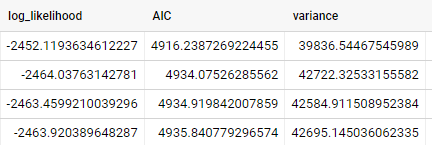

Te kolumny są wypełniane tylko wtedy, gdy dodaje kryterium: 

decompose_time_series = TRUE

Dotyczą one dni wolnych, skoków i spadków oraz skokowych zmian w wejściowych szeregach czasowych, które nie są związane z modelowaniem ARIMA dlatego wszystkie są takie same we wszystkich wierszach na wyjściu z wyjątkiem tych, które mają awarię. 

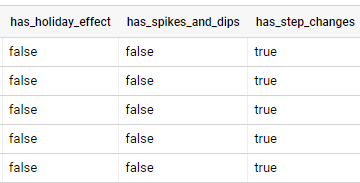

-- 5. Sprawdzam współczynniki modelu

Funkcja ML.ARIMA_COEFFICIENTS pobiera współcznynniki modelu ARIMA_PLUS

In [6]:
%%bigquery --project empik-ga360

SELECT *
FROM ML.ARIMA_COEFFICIENTS(MODEL pmackowka_ml.arima_model)

,ar_coefficients,ma_coefficients,intercept_or_drift
0,"[0.7326041489946651, -0.6713856216271604, -0.1...","[-1.142922969850245, 0.9490737330278333]",0.0


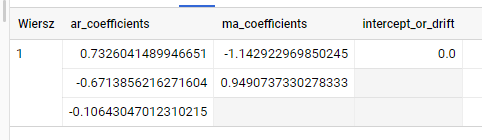

-- 6. Prognozowanie danych 30 dniowych na podstawie wytrenowanego modelu

Funkcja ML.FORECAST prognozuje przyszłe wartości szeregów czasowych za pomocą modelu: pmackowka_ml.arima_model

To jest prosty zapis QUERY:

In [7]:
%%bigquery --project empik-ga360

select *
from ML.FORECAST(MODEL `pmackowka_ml.arima_model`, 
                    struct(30 as horizon, 0.9 as confidence_level))

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2017-08-02 00:00:00+00:00,2639.810124,199.590943,0.9,2311.867998,2967.752250,2311.867998,2967.752250
1,2017-08-03 00:00:00+00:00,2677.479472,231.708142,0.9,2296.766503,3058.192441,2296.766503,3058.192441
2,2017-08-04 00:00:00+00:00,2492.094974,257.847235,0.9,2068.433615,2915.756333,2068.433615,2915.756333
3,2017-08-05 00:00:00+00:00,1829.892534,295.094987,0.9,1345.030467,2314.754602,1345.030467,2314.754602
4,2017-08-06 00:00:00+00:00,1887.971729,344.397870,0.9,1322.101515,2453.841942,1322.101515,2453.841942
5,2017-08-07 00:00:00+00:00,2531.917943,389.807473,0.9,1891.436520,3172.399365,1891.436520,3172.399365
6,2017-08-08 00:00:00+00:00,2578.270593,421.435253,0.9,1885.822477,3270.718709,1885.822477,3270.718709
7,2017-08-09 00:00:00+00:00,2693.281846,443.070324,0.9,1965.285768,3421.277924,1965.285768,3421.277924
8,2017-08-10 00:00:00+00:00,2695.072497,462.923751,0.9,1934.455826,3455.689168,1934.455826,3455.689168
9,2017-08-11 00:00:00+00:00,2462.865433,486.707797,0.9,1663.169881,3262.560985,1663.169881,3262.560985


To jest zapis dłuższy. Przy czym tworzę tabelę. 

In [8]:
%%bigquery --project empik-ga360

DECLARE HORIZON STRING DEFAULT "30"; # Liczba dni prognozy
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; # 90% poziom ufności

EXECUTE IMMEDIATE format("""
    CREATE OR REPLACE TABLE `empik-ga360.pmackowka_ml.prognoza` AS
    SELECT *
    FROM 
      ML.FORECAST(MODEL `pmackowka_ml.arima_model`, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """, HORIZON, CONFIDENCE_LEVEL)

""


-- 7. Wyjaśnij wyniki prognozy

Funkcja ML.EXPLAIN_FORECAST pobiera model, a także kilka opcjonalnych argumentów

In [14]:
%%bigquery --project empik-ga360

SELECT *
FROM
 ML.EXPLAIN_FORECAST(MODEL pmackowka_ml.arima_model,
                     STRUCT(30 AS horizon, 0.9 AS confidence_level))

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes
0,2016-08-01 00:00:00+00:00,history,1711.000000,513.567397,199.590943,NaN,NaN,NaN,0.000000,None,None,None,169.611938,None,None,None,1197.432603
1,2016-08-02 00:00:00+00:00,history,2140.000000,630.988612,199.590943,NaN,NaN,NaN,343.955338,None,None,None,287.033273,None,None,None,1197.432603
2,2016-08-03 00:00:00+00:00,history,2890.000000,1015.031030,199.590943,NaN,NaN,NaN,569.890152,None,None,None,445.140878,None,None,None,1197.432603
3,2016-08-04 00:00:00+00:00,history,3161.000000,1398.423140,199.590943,NaN,NaN,NaN,995.330786,None,None,None,403.092354,None,None,None,1197.432603
4,2016-08-05 00:00:00+00:00,history,2702.000000,1442.821574,199.590943,NaN,NaN,NaN,1297.133220,None,None,None,145.688355,None,None,None,1197.432603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2017-08-27 00:00:00+00:00,forecast,1905.246024,1905.246024,788.614246,0.9,609.496688,3200.995359,2379.284692,None,None,None,-474.038668,None,None,None,NaN
392,2017-08-28 00:00:00+00:00,forecast,2567.387171,2567.387171,803.100338,0.9,1247.836155,3886.938187,2380.948992,None,None,None,186.438179,None,None,None,NaN
393,2017-08-29 00:00:00+00:00,forecast,2600.932285,2600.932285,817.737031,0.9,1257.332140,3944.532430,2379.652420,None,None,None,221.279865,None,None,None,NaN
394,2017-08-30 00:00:00+00:00,forecast,2681.164569,2681.164569,832.421231,0.9,1313.437238,4048.891899,2377.215247,None,None,None,303.949322,None,None,None,NaN


-- 8. Łaczenie danych prognozowanych z historycznymi

In [9]:
%%bigquery --project empik-ga360

CREATE OR REPLACE TABLE `empik-ga360.pmackowka_ml.laczenie_danych`  AS
SELECT 
    true_date tmp, 
    'historyczne_sesje' typ, 
    sesje
FROM 
    `empik-ga360.pmackowka_ml.sesje` 
UNION ALL 
SELECT 
    forecast_timestamp tmp, 
    'estymacja_sesji' typ, 
    ROUND(forecast_value) sesje
FROM `empik-ga360.pmackowka_ml.prognoza` 

""


In [13]:
%%bigquery --project empik-ga360

SELECT * FROM `empik-ga360.pmackowka_ml.laczenie_danych` 
order by tmp desc
LIMIT 1000

,tmp,typ,sesje
0,2017-08-31 00:00:00+00:00,estymacja_sesji,2664.0
1,2017-08-30 00:00:00+00:00,estymacja_sesji,2681.0
2,2017-08-29 00:00:00+00:00,estymacja_sesji,2601.0
3,2017-08-28 00:00:00+00:00,estymacja_sesji,2567.0
4,2017-08-27 00:00:00+00:00,estymacja_sesji,1905.0
...,...,...,...
391,2016-08-05 00:00:00+00:00,historyczne_sesje,2702.0
392,2016-08-04 00:00:00+00:00,historyczne_sesje,3161.0
393,2016-08-03 00:00:00+00:00,historyczne_sesje,2890.0
394,2016-08-02 00:00:00+00:00,historyczne_sesje,2140.0


Wyniki analizy:

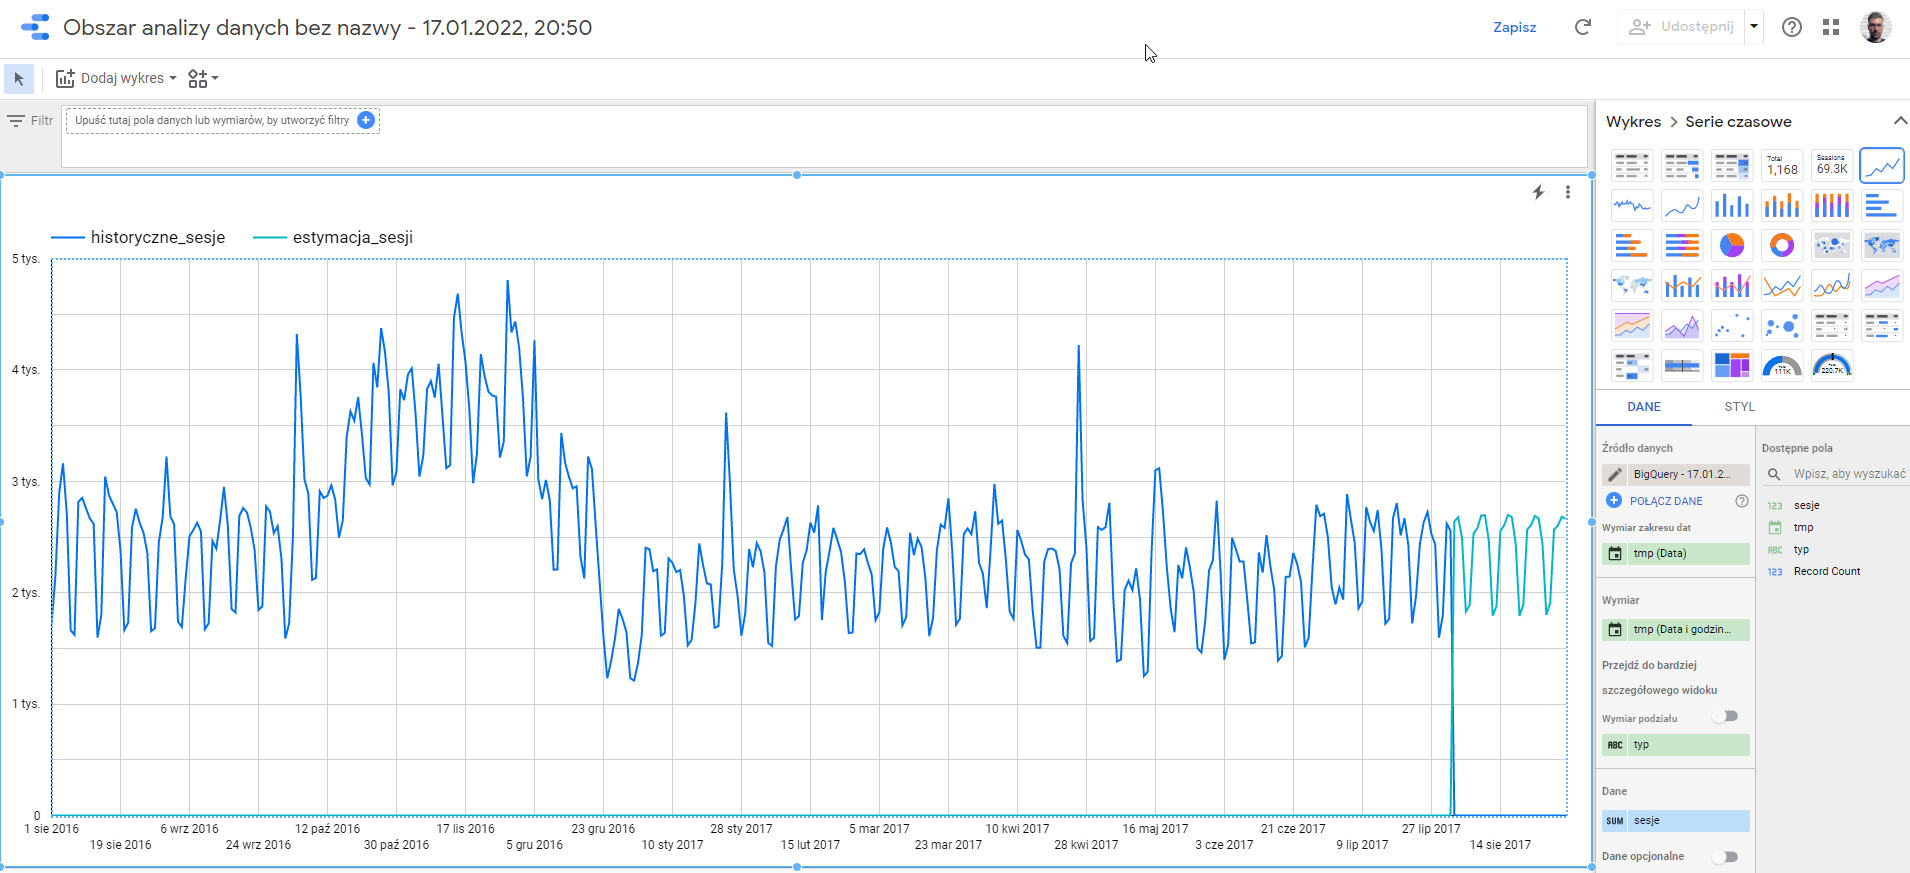

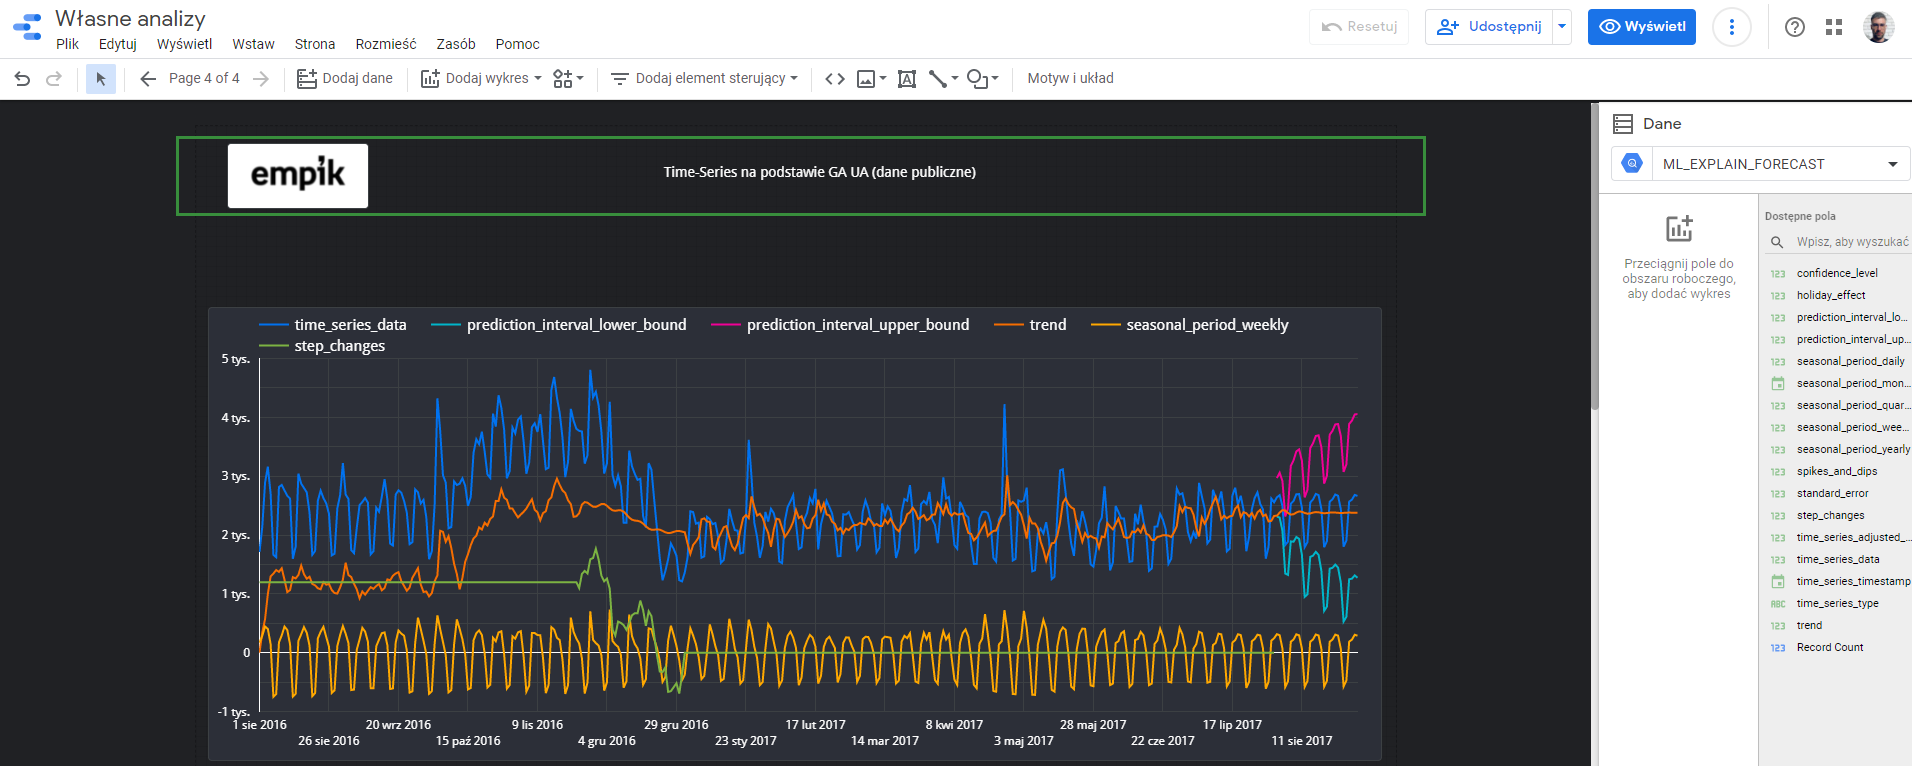

-- 9. Wyniki prognozy bez włączenia decompose_time_series

Jeżeli dla decompose_time_series = TRUE ustawiono wartość FALSE w ARIMA_PLUS można połączyć szeregi czasowe historii i prognozowane szeregi czasowe za pomocą UNION ALL i funkcji ML.FORECAST

In [2]:
%%bigquery --project empik-ga360

SELECT
    tmp AS timestamp,
    history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
FROM
 (
   SELECT
        true_date tmp, 
        sesje history_value
   FROM
        `empik-ga360.pmackowka_ml.sesje`
 )
UNION ALL
SELECT
    forecast_timestamp AS timestamp,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
FROM
 ML.FORECAST(MODEL pmackowka_ml.arima_model,
             STRUCT(30 AS horizon, 0.9 AS confidence_level))

,timestamp,history_value,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2017-08-02 00:00:00+00:00,NaN,2639.810124,2311.867998,2967.752250
1,2017-08-03 00:00:00+00:00,NaN,2677.479472,2296.766503,3058.192441
2,2017-08-04 00:00:00+00:00,NaN,2492.094974,2068.433615,2915.756333
3,2017-08-05 00:00:00+00:00,NaN,1829.892534,1345.030467,2314.754602
4,2017-08-06 00:00:00+00:00,NaN,1887.971729,1322.101515,2453.841942
...,...,...,...,...,...
391,2016-08-05 00:00:00+00:00,2702.0,NaN,NaN,NaN
392,2016-08-04 00:00:00+00:00,3161.0,NaN,NaN,NaN
393,2016-08-03 00:00:00+00:00,2890.0,NaN,NaN,NaN
394,2016-08-02 00:00:00+00:00,2140.0,NaN,NaN,NaN


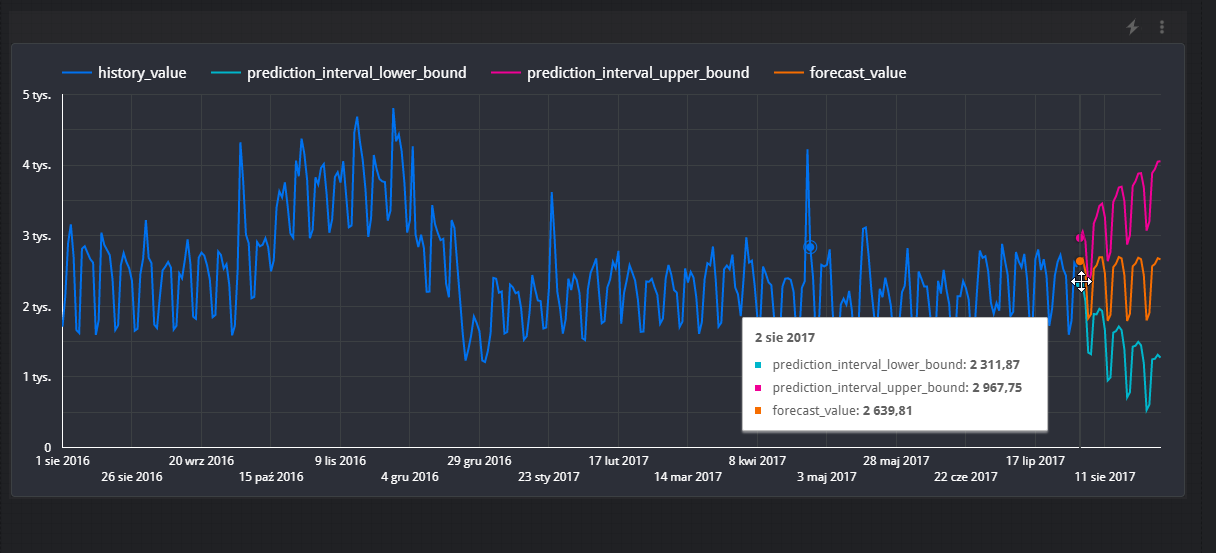